# Alternatives to differential abundance analysis for OOR state detection

We test the ability to detect OOR states without using differential abundance analysis, testing 3 alternatives:

1. Distance/segregation of OOR cells in latent space
2. Query-mapping quality control metrics
3. Differential expression analysis after label transfer

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import oor_benchmark
import oor_benchmark.metrics.utils

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_v2/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [5]:
%load_ext rpy2.ipython

In [6]:
%%R -i figdir
library(tidyverse)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [9]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

In [10]:

short_pop_names = {
    "DC":'conventional_dendritic_cell', 
    "naive B":'naive_B_cell',
    "memory B":'memory_B_cell',
    "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell', 
    'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
     "neutrophil":'neutrophil',
#     "cDC":'conventional_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
    'CD14+ monocyte':'CD14_positive_monocyte',
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte',
    "HPP":'hematopoietic_precursor_cell'
}

short_pop_names={v:k for k,v in short_pop_names.items()}

## Experiment set-up

See `submit_oor_design_v2.sh` for parameters

## Parse results 

In [11]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

In [12]:
## Get OOR state population size
oor_state_size = {}
for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_perturb')]:
        if 'neutrophil' not in d:
            acr_adata = sc.read_h5ad(outdir + d +'/acr_design.h5ad', backed=True)
            ct = acr_adata.obs[acr_adata.obs['OOR_state']==1]['cell_type'].unique()[0]
            oor_state_size[ct] = acr_adata.obs['OOR_state'].sum()

oor_state_frac = {k:v/(500*(14+16)) for k,v in oor_state_size.items()}
oor_state_frac

oor_state_size

{'CD14_low_CD16_positive_monocyte': 124,
 'erythrocyte': 10,
 'plasmablast': 15,
 'mucosal_invariant_T_cell': 203,
 'conventional_dendritic_cell': 108,
 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell': 396,
 'natural_killer_cell': 1067,
 'naive_B_cell': 601,
 'memory_B_cell': 398,
 'plasmacytoid_dendritic_cell': 43,
 'central_memory_CD4_positive_alpha_beta_T_cell': 1811,
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell': 779,
 'effector_memory_CD8_positive_alpha_beta_T_cell': 1436,
 'platelet': 123,
 'classical_monocyte': 391}

In [13]:
# nhoods_res_df_all = pd.DataFrame()
# tpr_res_df_all = pd.DataFrame()
# for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_perturb')]:
#     diff_method = 'milo'
#     for embedding_method in ['scVI', 'scArches']:
#         print(f'Reading {d}')
#         nhoods_res_df = pd.read_csv(outdir + d + f'/nhoods_obs.{embedding_method}_{diff_method}.csv', index_col = 0)
#         nhoods_res_df['emb_method'] = embedding_method
#         nhoods_res_df_all = pd.concat([nhoods_res_df_all, nhoods_res_df])
#         tpr_res_df = pd.read_csv(outdir + d + f'/TPR_res.{embedding_method}_{diff_method}.csv', index_col = 0)
#         tpr_res_df['emb_method'] = embedding_method
#         tpr_res_df_all = pd.concat([tpr_res_df_all, tpr_res_df])
# #         except:
# #             print('skipping')

In [14]:
# nhoods_res_df_all = nhoods_res_df_all[nhoods_res_df_all.OOR_state_name != 'neutrophil']
# tpr_res_df_all = tpr_res_df_all[tpr_res_df_all.OOR_state_name != 'neutrophil']

# nhoods_res_df_all['perturb_pop_pl'] = [short_pop_names[x] for x in nhoods_res_df_all['OOR_state_name']]
# tpr_res_df_all['perturb_pop_pl'] = [short_pop_names[x] for x in tpr_res_df_all['OOR_state_name']]

# ## Keep 4 designs
# nhoods_res_df_all['design'] = np.where(nhoods_res_df_all['design'] == 'CR', nhoods_res_df_all['design'] + ' ' + nhoods_res_df_all['emb_method'], nhoods_res_df_all['design'])
# tpr_res_df_all['design'] = np.where(tpr_res_df_all['design'] == 'CR', tpr_res_df_all['design'] + ' ' + tpr_res_df_all['emb_method'], tpr_res_df_all['design'])

# nhoods_res_df_all = nhoods_res_df_all[nhoods_res_df_all['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
# nhoods_res_df_all = nhoods_res_df_all[~((nhoods_res_df_all['design'] == 'ACR') & (nhoods_res_df_all['emb_method'] == 'scVI'))]
# tpr_res_df_all = tpr_res_df_all[tpr_res_df_all['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
# tpr_res_df_all = tpr_res_df_all[~((tpr_res_df_all['design'] == 'ACR') & (tpr_res_df_all['emb_method'] == 'scVI'))]

## 1. Distance/segregation of OOR cells in latent space

Here we want to test whether position in the latent space can always distinguish the OOR state. We train a KNN classifier to distinguish the OOR state in simulations with one removed OOR state.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def classify_OOR(adata, n_iters = 5, split_seed=42):
    '''Train classifier on latent space to identify OOR cell state in disease cells'''
    X = adata[adata.obs['dataset_group'] == 'query'].obsm['X_scVI'].copy()
    y = adata[adata.obs['dataset_group'] == 'query'].obs['OOR_state']
    class_out = {'precision':[], 'recall':[], 'f1-score':[], 'accuracy':[], 'support':[]}
    for s in np.arange(split_seed, split_seed+n_iters):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=s)

#         clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        clf = KNeighborsClassifier(n_neighbors=50, metric="euclidean").fit(X_train, y_train)
        class_out_iter = classification_report(y_test, clf.predict(X_test), output_dict=True)['1']
        class_out_iter['accuracy'] = classification_report(y_test, clf.predict(X_test), output_dict=True)['accuracy']
        for k in class_out.keys():
            class_out[k].append(class_out_iter[k])
    return(pd.DataFrame(class_out))

In [17]:
classifier_outs_all = pd.DataFrame()
for ct in [k for k,v in oor_state_size.items() if v > 100]: ## Select simulations with at least 100 cells in OOR state 
    d = f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'
    print(d)
    acr_adata = sc.read_h5ad(outdir + d + '/ACR_design.scArches_milo.h5ad', backed=True)
    acr_adata.uns["nhood_adata"] = sc.read_h5ad(outdir + d + '/ACR_design.scArches_milo.nhood_adata.h5ad', backed=True)
    ar_adata = sc.read_h5ad(outdir + d + '/ar_design.h5ad', backed=True)
    ar_adata.uns["nhood_adata"] = sc.read_h5ad(outdir + d + '/ar_design.nhood_adata.h5ad', backed=True)
    cr_adata = sc.read_h5ad(outdir + d + '/CR_design.scArches_milo.h5ad', backed=True)
    cr_adata.uns["nhood_adata"] = sc.read_h5ad(outdir + d + '/CR_design.scArches_milo.nhood_adata.h5ad', backed=True)
    cr_scvi_adata = sc.read_h5ad(outdir + d + '/CR_design.scVI_milo.h5ad', backed=True)
    cr_scvi_adata.uns["nhood_adata"] = sc.read_h5ad(outdir + d + '/CR_design.scVI_milo.nhood_adata.h5ad', backed=True)
    AR_classifier_outs = classify_OOR(ar_adata, split_seed=312, n_iters=10)
    AR_classifier_outs['design'] = 'AR'
    CR_classifier_outs = classify_OOR(cr_adata, split_seed=312, n_iters=10)
    CR_classifier_outs['design'] = 'CR scArches'
    CR_scVI_classifier_outs = classify_OOR(cr_scvi_adata, split_seed=312, n_iters=10)
    CR_scVI_classifier_outs['design'] = 'CR scVI'
    ACR_classifier_outs = classify_OOR(acr_adata, split_seed=312, n_iters=10)
    ACR_classifier_outs['design'] = 'ACR'
    classifier_outs = pd.concat([ACR_classifier_outs, AR_classifier_outs, CR_classifier_outs, CR_scVI_classifier_outs])
    classifier_outs['OOR_state_name'] = ct
    classifier_outs_all = pd.concat([classifier_outs_all, classifier_outs])

qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
qPBMC_500cells_demo_pertur

In [18]:
classifier_outs_all.to_csv('../../../metadata/outputs/OOR_knn_classifier.results.csv')

In [19]:
classifier_outs_all

,precision,recall,f1-score,accuracy,support,design,OOR_state_name
0,0.934783,0.977273,0.955556,0.998385,44,ACR,CD14_low_CD16_positive_monocyte
1,0.878049,0.972973,0.923077,0.997578,37,ACR,CD14_low_CD16_positive_monocyte
2,0.893617,1.000000,0.943820,0.997981,42,ACR,CD14_low_CD16_positive_monocyte
3,0.979167,0.959184,0.969072,0.998789,49,ACR,CD14_low_CD16_positive_monocyte
4,0.925000,1.000000,0.961039,0.998789,37,ACR,CD14_low_CD16_positive_monocyte
...,...,...,...,...,...,...,...
5,0.992248,0.992248,0.992248,0.999193,129,CR scVI,classical_monocyte
6,0.972727,0.972727,0.972727,0.997578,110,CR scVI,classical_monocyte
7,0.984252,0.968992,0.976562,0.997578,129,CR scVI,classical_monocyte
8,0.960317,0.975806,0.968000,0.996770,124,CR scVI,classical_monocyte


In [21]:
classifier_outs_all['OOR_state_name'] = [short_pop_names[x] for x in classifier_outs_all.OOR_state_name]

In [22]:
%%R -i classifier_outs_all
head(classifier_outs_all)

  precision    recall  f1-score  accuracy support design OOR_state_name
1 0.8549618 0.8296296 0.8421053 0.9830440     135    ACR       memory B
2 0.8805970 0.8251748 0.8519856 0.9834477     143    ACR       memory B
3 0.8145695 0.8482759 0.8310811 0.9798143     145    ACR       memory B
4 0.8345324 0.7945205 0.8140351 0.9786031     146    ACR       memory B
5 0.8059701 0.8571429 0.8307692 0.9822366     126    ACR       memory B
6 0.8031496 0.8095238 0.8063241 0.9802180     126    ACR       memory B


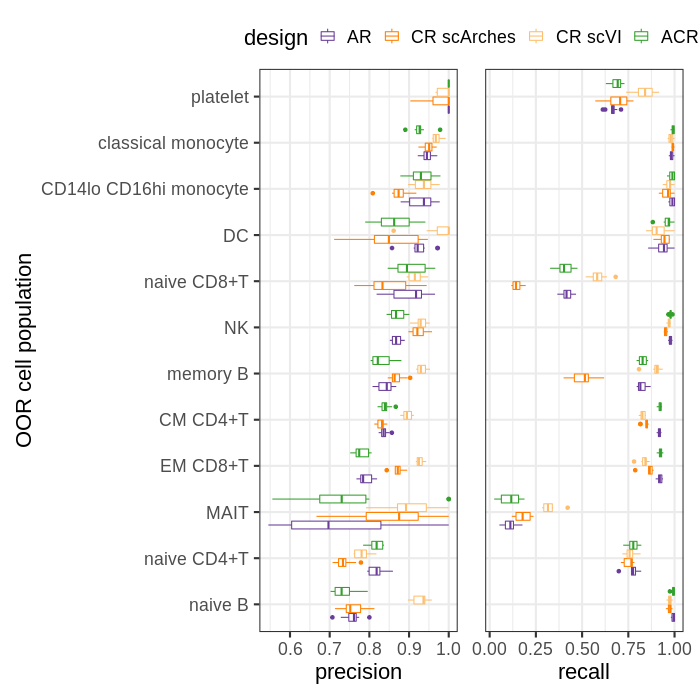

In [24]:
%%R -w 700 -h 700
pl_df <- classifier_outs_all %>%
    group_by(OOR_state_name) %>%
    mutate(mean_precision = median(precision), mean_accuracy = median(accuracy)) %>%
    ungroup() %>%
    arrange(mean_precision) %>%
    mutate(OOR_state_name = factor(OOR_state_name, levels=unique(OOR_state_name))) %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", 'CR scVI', "ACR"))) 
    
p1 <- pl_df %>%
    ggplot(aes(OOR_state_name, precision, color=design)) +
    geom_boxplot() +
    scale_color_manual(values=design_palette) +
    coord_flip() +
    theme_bw(base_size=22) +
    xlab('OOR cell population') +
    theme(legend.position='top')

p2 <- pl_df %>%
    ggplot(aes(OOR_state_name, `recall`, color=design)) +
    geom_boxplot() +
    scale_color_manual(values=design_palette) +
    coord_flip() +
    theme_bw(base_size=22) +
    theme(legend.position='top')
    
(p1 + (p2 + remove_y_axis()) + plot_layout(guides='collect') & theme(legend.position='top')) +
ggsave(paste0(figdir, 'OOR_state_classifier_precision_recall.png'), width=12, height=7) +
ggsave(paste0(figdir, 'OOR_state_classifier_precision_recall.pdf'), width=12, height=7)

## 2. Comparison to mapping QC metrics

Compute label transfer QC and reconstruction error

See `submit_mappingQC.sh` for parameters

Parse results

In [19]:
def get_mean_confidence_x_nhood(adata, obs_names, confidence_col = 'conf_gex'):
    '''
    Compute average confidence per neighbourhood using a subset of cells
    '''
    nhood_mat = adata[obs_names].obsm['nhoods']
    mean_conf_nhoods = nhood_mat.T.dot(
            scipy.sparse.csr_matrix(adata.obs.loc[obs_names, confidence_col]).T)
    mean_conf_nhoods = mean_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
    mean_conf_nhoods = np.nan_to_num(mean_conf_nhoods, 0) ## zero confidence where we have no cells
    return(mean_conf_nhoods)

def harmonize_output(adata, signif_alpha=0.1):
    if adata.isbacked:
        sample_adata = adata.uns['nhood_adata'].to_memory().T
    else:
        sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()
   

In [20]:
 
mappingQC_nhoods_all = pd.DataFrame()
for d in os.listdir(outdir):
    if not d.endswith('.h5ad') and not d.endswith('.pkl') and d.startswith('qPBMC'):
        if 'neutrophil' not in d:
            print(f'Reading {d}')
            acr_adata = milopy.utils.read_milo_adata(outdir + d + '/acr_design.h5ad', backed='r')
            for m in ['labels', 'reconstruction']:
                mappingQC_res_df = pd.read_csv(outdir + d + f'/ar_design.mappingQC_{m}.csv', index_col = 0)

                ## Add mappingQC metric
                acr_adata.obs[f'mappingQC_{m}'] = np.nan
                acr_adata.obs.loc[mappingQC_res_df.index, f'mappingQC_{m}'] = mappingQC_res_df[f'mappingQC_{m}']

                ## Compute avg mappingQC metric per nhood
                acr_adata.uns['nhood_adata'].obs[f'mean_mappingQC_{m}'] = get_mean_confidence_x_nhood(
                    acr_adata, acr_adata.obs_names[acr_adata.obs_names.isin(mappingQC_res_df.index)],
                    confidence_col=f'mappingQC_{m}'
                ).ravel()
                
            harmonize_output(acr_adata)
            oor_benchmark.metrics.utils.make_OOR_per_group(acr_adata)

            nhoods_out_df = acr_adata.uns['sample_adata'].var.copy()
            nhoods_out_df['d'] = d
            mappingQC_nhoods_all = pd.concat([mappingQC_nhoods_all, nhoods_out_df])


mappingQC_nhoods_all['design'] = 'AR'
mappingQC_nhoods_all['OOR_state_name'] = [x[-1].split('_query')[0] for x in mappingQC_nhoods_all['d'].str.split("cell_type")]

Reading qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2

In [21]:
mappingQC_nhoods_all

,index_cell,kth_distance,nhood_annotation,nhood_annotation_frac,logFC,logCPM,F,PValue,FDR,SpatialFDR,mean_mappingQC_labels,mean_mappingQC_reconstruction,OOR_score,OOR_signif,n_OOR_cells,frac_OOR_cells,OOR_state_group,d,design,OOR_state_name
0,10_1038_s41591_021_01329_2-CGCGTTTTCCTAGGGC-MH...,1.871045,natural_killer_cell,0.828767,-0.497593,10.073818,1.037823e+00,0.313319,0.884221,0.884921,0.074451,0.242772,-0.497593,0,0.0,0.00000,0,qPBMC_500cells_demo_perturb_cell_typememory_B_...,AR,memory_B_cell
1,10_1038_s41591_021_01329_2-TTTCCTCAGGCGTACA-MH...,2.511474,plasmacytoid_dendritic_cell,0.607843,1.259110,9.730400,6.349112e+00,0.015020,0.264078,0.270040,0.062245,0.240509,1.259110,0,60.0,0.37037,1,qPBMC_500cells_demo_perturb_cell_typememory_B_...,AR,memory_B_cell
2,10_1038_s41591_021_01329_2-CCGTACTGTTCGGGCT-MH...,1.641383,classical_monocyte,0.979592,-1.712137,10.629959,6.693454e+00,0.012712,0.248942,0.252890,0.032437,0.231754,-1.712137,0,0.0,0.00000,0,qPBMC_500cells_demo_perturb_cell_typememory_B_...,AR,memory_B_cell
3,10_1038_s41591_021_01329_2-GGGCACTAGCTAACTC-MH...,1.837092,natural_killer_cell,0.762821,-0.944727,10.373903,3.259362e+00,0.077194,0.575895,0.582552,0.146945,0.282051,-0.944727,0,0.0,0.00000,0,qPBMC_500cells_demo_perturb_cell_typememory_B_...,AR,memory_B_cell
4,10_1038_s41591_021_01329_2-AACTCCCTCTCTGCTG-MH...,1.616541,natural_killer_cell,0.950000,-1.147661,10.311019,4.860469e+00,0.032230,0.378697,0.381139,0.022522,0.268444,-1.147661,0,0.0,0.00000,0,qPBMC_500cells_demo_perturb_cell_typememory_B_...,AR,memory_B_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10_1038_s41591_021_01329_2-TTGGCAAGTTGGACCC-MH...,1.453310,naive_B_cell,0.991525,0.359222,10.388177,3.657575e-01,0.548085,1.000000,1.000000,0.030736,0.266802,0.359222,0,0.0,0.00000,0,qPBMC_500cells_demo_perturb_cell_typeCD14_low_...,AR,CD14_low_CD16_positive_monocyte
996,10_1038_s41591_021_01329_2-AAGGAGCCAGATGGGT-MH...,1.297452,naive_B_cell,0.909091,0.007185,10.807078,-1.375875e-08,1.000000,1.000000,1.000000,0.058777,0.266971,0.007185,0,0.0,0.00000,0,qPBMC_500cells_demo_perturb_cell_typeCD14_low_...,AR,CD14_low_CD16_positive_monocyte
997,10_1038_s41591_021_01329_2-ACTATCTCAGTATCTG-MH...,1.865222,central_memory_CD4_positive_alpha_beta_T_cell,0.440945,-0.032135,10.295449,4.014793e-03,0.949729,1.000000,1.000000,0.252329,0.239632,-0.032135,0,0.0,0.00000,0,qPBMC_500cells_demo_perturb_cell_typeCD14_low_...,AR,CD14_low_CD16_positive_monocyte
998,10_1038_s41591_021_01329_2-ACGAGCCAGCGAGAAA-MH...,1.493588,naive_B_cell,0.976923,-0.125698,10.166201,5.931539e-02,0.808587,1.000000,1.000000,0.033095,0.254019,-0.125698,0,0.0,0.00000,0,qPBMC_500cells_demo_perturb_cell_typeCD14_low_...,AR,CD14_low_CD16_positive_monocyte


### Compute AUPRC on neighbourhoods

In [22]:
from oor_benchmark.metrics import auprc
AUPRC_df_mappingQC = pd.DataFrame()
for p in mappingQC_nhoods_all['OOR_state_name'].unique():
    for m in ['mean_mappingQC_labels', 'mean_mappingQC_reconstruction', 'logFC']:
        mappingQC_res_df = mappingQC_nhoods_all[mappingQC_nhoods_all['OOR_state_name'] == p].copy()
        mappingQC_res_df['OOR_score'] = mappingQC_res_df[m].copy()
        
        df = auprc.auprc(mappingQC_res_df)
        df['OOR_state_name'] = p
        df['metric'] = m
        
        AUPRC_df_mappingQC = pd.concat([AUPRC_df_mappingQC, df])

In [23]:
AUPRC_df_mappingQC

,AUPRC,no_skill_thresh,OOR_state_name,metric
0,0.039109,0.069149,memory_B_cell,mean_mappingQC_labels
0,0.086593,0.069149,memory_B_cell,mean_mappingQC_reconstruction
0,0.773721,0.069149,memory_B_cell,logFC
0,0.005485,0.008163,conventional_dendritic_cell,mean_mappingQC_labels
0,0.004110,0.008163,conventional_dendritic_cell,mean_mappingQC_reconstruction
0,0.288989,0.008163,conventional_dendritic_cell,logFC
0,0.052769,0.101266,naive_B_cell,mean_mappingQC_labels
0,0.162779,0.101266,naive_B_cell,mean_mappingQC_reconstruction
0,0.889435,0.101266,naive_B_cell,logFC
0,0.294354,0.246294,central_memory_CD4_positive_alpha_beta_T_cell,mean_mappingQC_labels


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


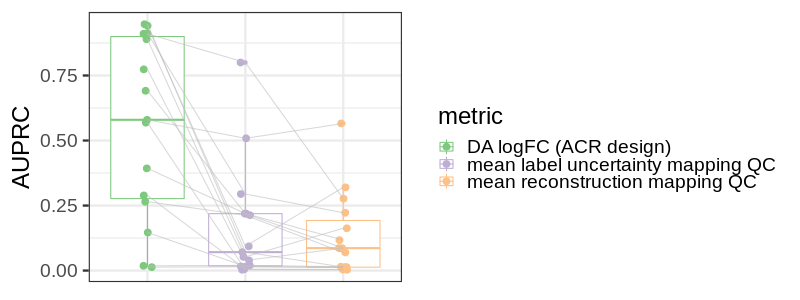

In [23]:
%%R -i AUPRC_df_mappingQC -w 800 -h 300
AUPRC_df_mappingQC %>%
    ggplot(aes(metric, AUPRC, color=metric)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    scale_color_brewer(palette='Accent', 
                       labels=c(logFC='DA logFC (ACR design)', 
                           mean_mappingQC_reconstruction = 'mean reconstruction mapping QC', 
                           mean_mappingQC_labels = 'mean label uncertainty mapping QC')) +
    theme_bw(base_size=24) +
    remove_x_axis() +
    ggsave(paste0(figdir, "mappingQC_AUPRC.pdf"), width=10, height=5) +
    ggsave(paste0(figdir, "mappingQC_AUPRC.png"), width=10, height=5) 
    

### Compute AUPRC on cells

#### Reconstruction

In [24]:
mappingQC_res_df_all = pd.DataFrame()
for d in os.listdir(outdir):
    if not d.endswith('.h5ad') and not d.endswith('.pkl') and d.startswith('qPBMC'):
        if 'neutrophil' not in d:
            print(f'Reading {d}')
            mappingQC_res_df = pd.read_csv(outdir + d + '/ar_design.mappingQC_reconstruction.csv', index_col = 0)
            mappingQC_res_df['d'] = d
            mappingQC_res_df_all = pd.concat([mappingQC_res_df_all, mappingQC_res_df])


mappingQC_res_df_all['design'] = 'AR'
mappingQC_res_df_all['OOR_state_name'] = [x[-1].split('_query')[0] for x in mappingQC_res_df_all['d'].str.split("cell_type")]
mappingQC_res_df_all['OOR_score'] = mappingQC_res_df_all['mappingQC_reconstruction'].copy()
mappingQC_res_df_all['OOR_state_group'] = mappingQC_res_df_all['OOR_state'].copy()
mappingQC_res_df_all['OOR_state_name_pl'] = [short_pop_names[x] for x in mappingQC_res_df_all['OOR_state_name']]

Reading qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2

In [25]:
AUPRC_df_mappingQC = pd.DataFrame()
for p in mappingQC_res_df_all['OOR_state_name_pl'].unique():
    df = auprc.auprc(mappingQC_res_df_all[mappingQC_res_df_all['OOR_state_name_pl'] == p])
    df['OOR_state_name_pl'] = p
    AUPRC_df_mappingQC = pd.concat([AUPRC_df_mappingQC, df])

In [26]:
%%R -i mappingQC_res_df_all
head(mappingQC_res_df_all)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  mappingQC_reconstruction OOR_state
1                0.2753007         0
2                0.2703676         0
3                0.3488741         0
4                0.1957048         0
5                0.1957743         0
6                0.3073377         0
                                                                                                           d
1 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
2 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
3 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
4 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
5 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
6 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591

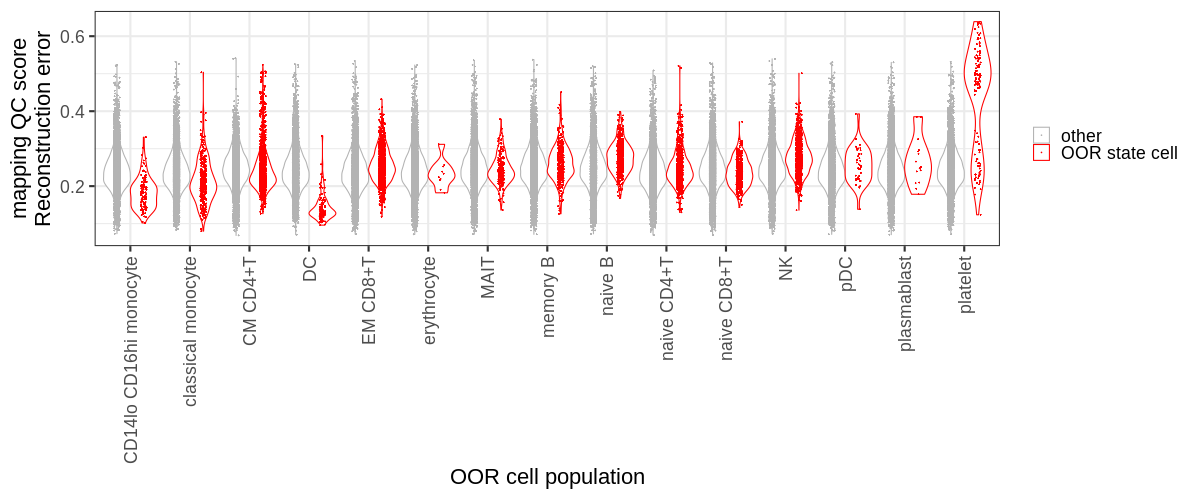

In [27]:
%%R -w 1200 -h 500 -i figdir
recon_pl <- mappingQC_res_df_all %>%
    mutate(OOR_state = factor(ifelse(OOR_state == 1, "OOR state cell", "other"), levels=c('other', 'OOR state cell'))) %>%
    ggplot(aes(OOR_state_name_pl, OOR_score, color=OOR_state)) +
    geom_violin(scale='width') +
    rasterize(geom_point(position=position_jitterdodge(jitter.width=0.2, dodge.width = 0.9), size=0.1), dpi=400) +
    theme_bw(base_size=22) +
    xlab('OOR cell population') + ylab("mapping QC score\nReconstruction error") +
    scale_color_manual(values=c(`OOR state cell` = 'red', other = 'grey70'), name='') +
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
    ggsave(paste0(figdir, "mappingQC_violin_reconstruction.pdf"), width=15, height=8) +
    ggsave(paste0(figdir, "mappingQC_violin_reconstruction.png"), width=15, height=8) 
recon_pl

#### Label transfer score

In [28]:
mappingQC_res_df_all = pd.DataFrame()
for d in os.listdir(outdir):
    if not d.endswith('.h5ad') and not d.endswith('.pkl') and d.startswith('qPBMC'):
        if 'neutrophil' not in d:
            print(f'Reading {d}')
            mappingQC_res_df = pd.read_csv(outdir + d + '/ar_design.mappingQC_labels.csv', index_col = 0)
            mappingQC_res_df['d'] = d
            mappingQC_res_df_all = pd.concat([mappingQC_res_df_all, mappingQC_res_df])


mappingQC_res_df_all['design'] = 'AR'
mappingQC_res_df_all['OOR_state_name'] = [x[-1].split('_query')[0] for x in mappingQC_res_df_all['d'].str.split("cell_type")]
mappingQC_res_df_all['OOR_score'] = mappingQC_res_df_all['mappingQC_labels'].copy()
mappingQC_res_df_all['OOR_state_group'] = mappingQC_res_df_all['OOR_state'].copy()
mappingQC_res_df_all['OOR_state_name_pl'] = [short_pop_names[x] for x in mappingQC_res_df_all['OOR_state_name']]

Reading qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeconventional_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmacytoid_dendritic_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typenaive_thymus_derived_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2

In [29]:
AUPRC_df_mappingQC = pd.DataFrame()
for p in mappingQC_res_df_all['OOR_state_name_pl'].unique():
    df = auprc.auprc(mappingQC_res_df_all[mappingQC_res_df_all['OOR_state_name_pl'] == p])
    df['OOR_state_name_pl'] = p
    AUPRC_df_mappingQC = pd.concat([AUPRC_df_mappingQC, df])

In [30]:
%%R -i mappingQC_res_df_all
head(mappingQC_res_df_all)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  mappingQC_labels OOR_state
1     5.960464e-08         0
2     3.699886e-01         0
3     9.998143e-03         0
4     0.000000e+00         0
5     0.000000e+00         0
6     3.998888e-02         0
                                                                                                           d
1 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
2 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
3 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
4 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
5 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
6 qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
  design OOR_state_name    OOR_sco

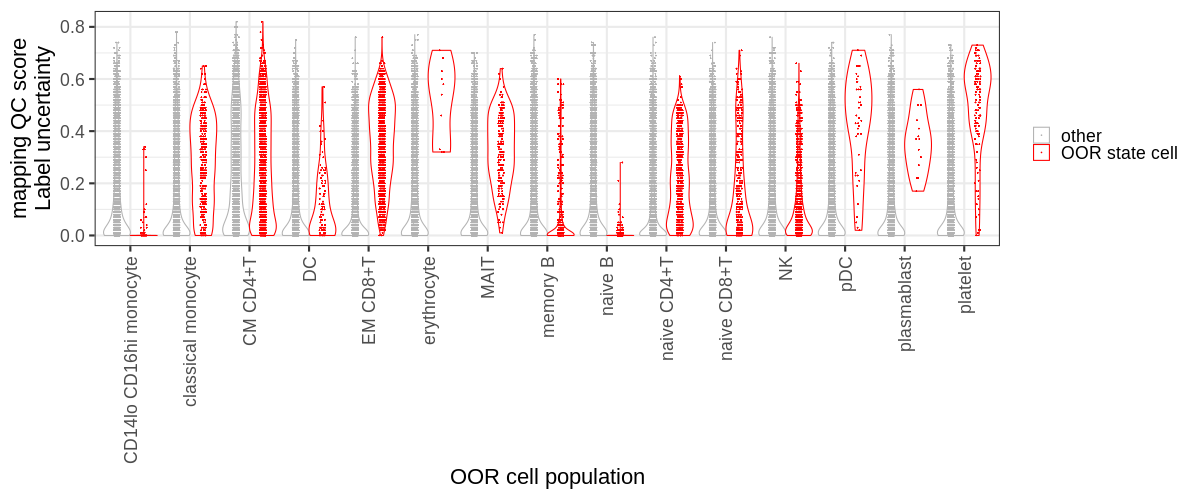

In [31]:
%%R -w 1200 -h 500 -i figdir
label_pl <- mappingQC_res_df_all %>%
    mutate(OOR_state = factor(ifelse(OOR_state == 1, "OOR state cell", "other"), levels=c('other', 'OOR state cell'))) %>%
    ggplot(aes(OOR_state_name_pl, OOR_score, color=OOR_state)) +
    geom_violin(scale='width') +
    rasterize(geom_point(position=position_jitterdodge(jitter.width=0.2, dodge.width = 0.9), size=0.1), dpi=400) +
    theme_bw(base_size=22) +
    xlab('OOR cell population') + ylab("mapping QC score\nLabel uncertainty") +
    scale_color_manual(values=c(`OOR state cell` = 'red', other = 'grey70'), name='') +
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
    ggsave(paste0(figdir, "mappingQC_violin_labels.pdf"), width=15, height=5) +
    ggsave(paste0(figdir, "mappingQC_violin_labels.png"), width=15, height=5) 
label_pl

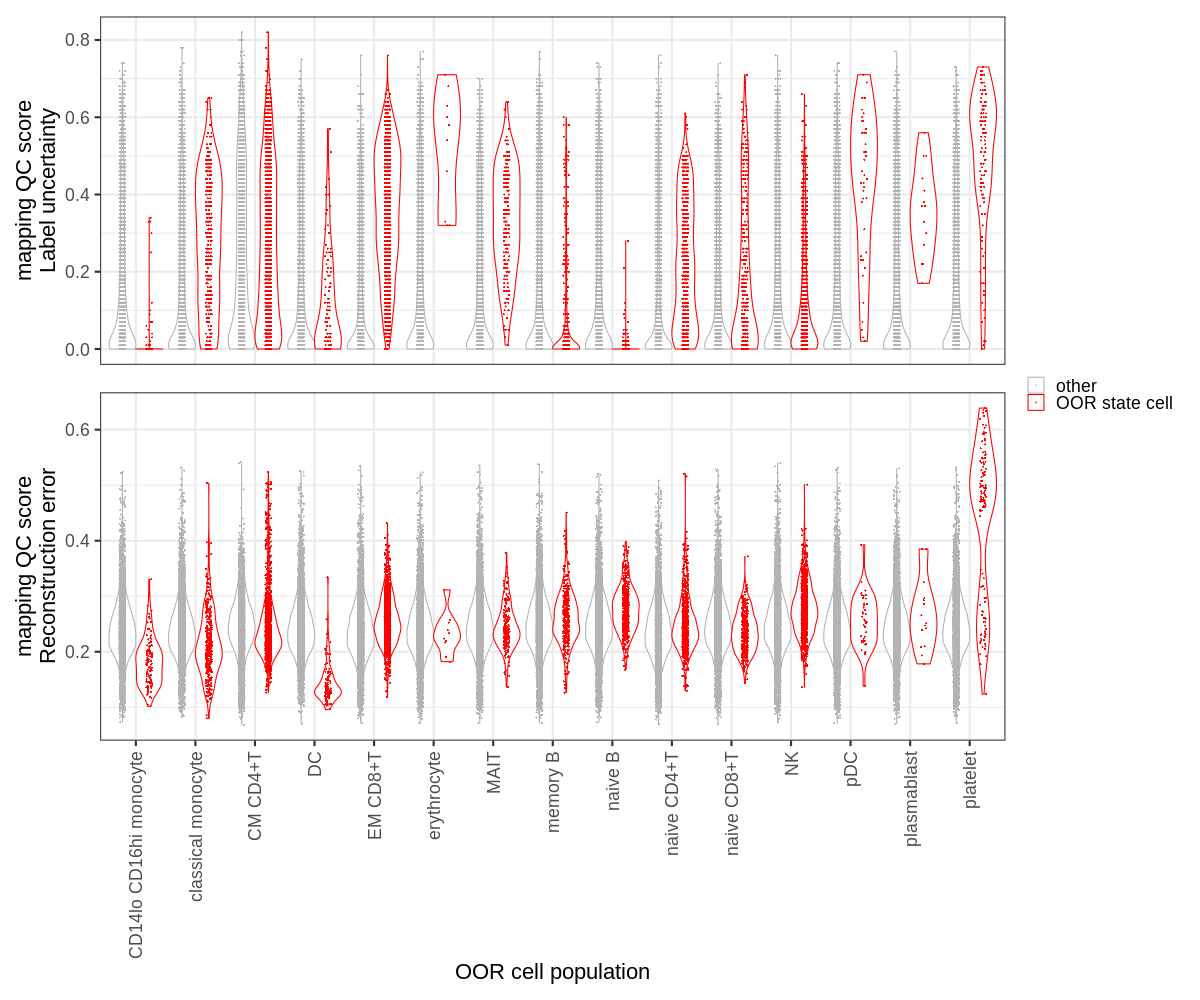

In [32]:
%%R -w 1200 -h 1000
((label_pl + remove_x_axis()) /recon_pl ) +
    plot_layout(guides='collect') +
    ggsave(paste0(figdir, "mappingQC_violin.pdf"), width=15, height=10) +
    ggsave(paste0(figdir, "mappingQC_violin.png"), width=15, height=10)

### Compare mapping QC between control and query

In [26]:
import oor_benchmark.metrics

In [20]:
from oor_benchmark.methods.scArches_mappingQC import _weighted_knn_transfer_uncertainty
import oor_benchmark.metrics

In [27]:
embedding_reference = 'atlas'
m = 'labels'
# mappingQC_delta_all = pd.DataFrame()
mappingQC_delta_all = pd.read_csv(outdir + 'mappingQC_labels_delta_all.csv')

In [28]:
for d in os.listdir(outdir):
    if not d.endswith('.h5ad') and not d.endswith('.pkl') and d.startswith('qPBMC'):
        if 'neutrophil' not in d:
            if d not in mappingQC_delta_all['d'].unique().tolist():
                print(f"Reading {d}")
                acr_adata = milopy.utils.read_milo_adata(outdir + d + '/acr_design.h5ad', backed='r')
                ar_adata = sc.read_h5ad(outdir + d + '/ar_design.h5ad', backed='r') ## Load labels
                train_labels = ar_adata.obs[ar_adata.obs['dataset_group'] == embedding_reference]['cell_annotation']

                # Compute label transfer probability
                mappingQC_labels = _weighted_knn_transfer_uncertainty(
                    outdir + d + f"/weighted_KNN_classifier.{embedding_reference}.pkl",
                    query_adata=acr_adata[acr_adata.obs["dataset_group"] != embedding_reference],
                    train_labels = train_labels,
                    )["pred_uncertainty"]

                acr_adata.obs['mappingQC_labels'] = mappingQC_labels.astype('float')


                ## Compute avg mappingQC metric per nhood per dataset group
                acr_adata.uns['nhood_adata'].obs[f'mean_mappingQC_{m}_query'] = get_mean_confidence_x_nhood(
                    acr_adata, acr_adata.obs_names[acr_adata.obs['dataset_group'] == 'query'],
                    confidence_col=f'mappingQC_{m}'
                ).ravel()

                acr_adata.uns['nhood_adata'].obs[f'mean_mappingQC_{m}_ctrl'] = get_mean_confidence_x_nhood(
                    acr_adata, acr_adata.obs_names[acr_adata.obs['dataset_group'] == 'ctrl'],
                    confidence_col=f'mappingQC_{m}'
                ).ravel()

                ## Compute delta btw mappingQC in query and ctrl
                acr_adata.uns['nhood_adata'].obs[f'mappingQC_delta'] = acr_adata.uns['nhood_adata'].obs[f'mean_mappingQC_{m}_query'] - acr_adata.uns['nhood_adata'].obs[f'mean_mappingQC_{m}_ctrl']

                ## Get output
                harmonize_output(acr_adata)
                oor_benchmark.metrics.utils.make_OOR_per_group(acr_adata)
                nhoods_out_df = acr_adata.uns['sample_adata'].var.copy()
                nhoods_out_df['d'] = d
                mappingQC_delta_all = pd.concat([mappingQC_delta_all, nhoods_out_df])

Reading qPBMC_500cells_demo_perturb_cell_typenatural_killer_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022


In [34]:
mappingQC_delta_all['design'] = 'AR'
mappingQC_delta_all['OOR_state_name'] = [x[-1].split('_query')[0] for x in mappingQC_delta_all['d'].str.split("cell_type")]

In [35]:
mappingQC_delta_all.to_csv(outdir + 'mappingQC_labels_delta_all.csv')

In [44]:
AUPRC_df_mappingQC_delta = pd.DataFrame()
for p in mappingQC_delta_all['OOR_state_name'].unique():
    for m in ['mappingQC_delta', 'logFC']:
        mappingQC_res_df = mappingQC_delta_all[mappingQC_delta_all['OOR_state_name'] == p].copy()
        mappingQC_res_df['OOR_score'] = mappingQC_res_df[m].copy()
        
        df = auprc.auprc(mappingQC_res_df)
        df['OOR_state_name'] = p
        df['metric'] = m
        
        AUPRC_df_mappingQC_delta = pd.concat([AUPRC_df_mappingQC_delta, df])

In [51]:
AUPRC_df_mappingQC_delta = pd.concat([AUPRC_df_mappingQC_delta, AUPRC_df_mappingQC[AUPRC_df_mappingQC['metric'] == 'mean_mappingQC_labels']])


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


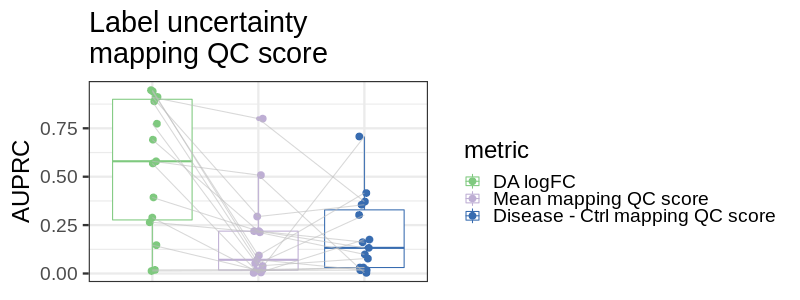

In [61]:
%%R -i AUPRC_df_mappingQC_delta -w 800 -h 300
my_colors <- RColorBrewer::brewer.pal(7, "Accent")[c(1,2,5)]

AUPRC_df_mappingQC_delta %>%
    mutate(metric = factor(metric, levels=c('logFC', 'mean_mappingQC_reconstruction','mean_mappingQC_labels', 'mappingQC_delta'))) %>%
    ggplot(aes(metric, AUPRC, color=metric)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    scale_color_manual(values=my_colors,
                       labels=c(logFC='DA logFC', 
                           mappingQC_delta = 'Disease - Ctrl mapping QC score', 
                           mean_mappingQC_labels = 'Mean mapping QC score')) +
    theme_bw(base_size=24) +
    remove_x_axis() +
    ggtitle('Label uncertainty\nmapping QC score') +
    ggsave(paste0(figdir, "mappingQC_AUPRC_delta.pdf"), width=10, height=5) +
    ggsave(paste0(figdir, "mappingQC_AUPRC_delta.png"), width=10, height=5) 
    

## 3. Label transfer and differential expression analysis

Here we test whether OOR states can be distinguished by performing label transfer from reference to disease dataset, followed by differential expression analysis between disease and reference within each cluster.

See `submit_DE_comparison.sh`

## Parse results

In [34]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_type') and x.endswith('_seed2022')]

res_df_all = pd.DataFrame()
for d in dirs:
    acr_results = pd.read_csv(outdir + d + '/DE_comparison_results.ACR_scArches.csv')
    try:
        ar_results = pd.read_csv(outdir + d + '/DE_comparison_results.AR_scArches.csv')
    except:
        pass
    cr_scvi_results = pd.read_csv(outdir + d + '/DE_comparison_results.CR_scVI.csv')
    cr_scvi_results['design'] = cr_scvi_results['design'] + ' scVI'
    cr_scarches_results = pd.read_csv(outdir + d + '/DE_comparison_results.CR_scArches.csv')
    cr_scarches_results['design'] = cr_scarches_results['design'] + ' scArches'
    res_df = pd.concat([acr_results, ar_results, cr_scvi_results, cr_scarches_results])
    res_df_all = pd.concat([res_df_all, res_df])

In [35]:
res_df_all['perturb_pop_pl'] = [short_pop_names[x] for x in res_df_all['OOR_state_simulation']]

In [36]:
%%R -i res_df_all
head(res_df_all)

                              DE_cell_annotation OOR_state affected_anno
1                CD14_low_CD16_positive_monocyte         0         FALSE
2  central_memory_CD4_positive_alpha_beta_T_cell         2         FALSE
3                             classical_monocyte         0         FALSE
4                    conventional_dendritic_cell         3         FALSE
5 effector_memory_CD8_positive_alpha_beta_T_cell         0         FALSE
6                                    erythrocyte         0         FALSE
          FPR TPR design OOR_state_simulation perturb_pop_pl
1 0.000000000 NaN    ACR        memory_B_cell       memory B
2 0.000000000 NaN    ACR        memory_B_cell       memory B
3 0.000000000 NaN    ACR        memory_B_cell       memory B
4 0.000262605 NaN    ACR        memory_B_cell       memory B
5 0.000000000 NaN    ACR        memory_B_cell       memory B
6         NaN NaN    ACR        memory_B_cell       memory B


In [37]:
%%R -w 1000 -h 700 -o pl_df
pl_df <-res_df_all %>%
    filter(affected_anno) %>%
    mutate(TPR=ifelse(is.na(TPR), 0, TPR)) %>%
    group_by(OOR_state_simulation, design) %>%
    mutate(frac_OOR_state = OOR_state/sum(OOR_state)) %>%
    slice_max(TPR, with_ties=FALSE) %>%
    ungroup() %>%
    group_by(OOR_state_simulation) %>%
    mutate(mean_tpr= median(TPR)) %>%
    ungroup() %>%
    arrange(mean_tpr) %>%
    mutate(perturb_pop_pl = factor(perturb_pop_pl, levels=unique(perturb_pop_pl))) %>%
    mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) 

pl2 <- pl_df %>%
    ggplot(aes(perturb_pop_pl, TPR, color=design)) +
    # geom_line(aes(group=design, color=design)) +
    geom_jitter(aes(size=frac_OOR_state), width=0.1, alpha=0.7) +
    # facet_grid(design~.) +
    scale_color_manual(values=design_palette) +
    scale_size(range=c(2,6), name='Fraction of\nOOR cells') +
    theme_bw(base_size=18) +
    xlab('OOR cell state') +
    ylab('OOR state marker gene recall\n(top 50 celltypist marker genes)') +
    guides(color=guide_legend(override.aes=c(size=5))) +
    coord_flip() +
    ggtitle('Affected clusters')

In [38]:
%%R -w 1200 -h 500
pl1 <- res_df_all %>%
filter(!affected_anno) %>%
mutate(FPR=ifelse(is.na(FPR), 0, FPR)) %>%
mutate(perturb_pop_pl = factor(perturb_pop_pl, levels=levels(pl_df$perturb_pop_pl))) %>%
filter(!is.na(perturb_pop_pl)) %>%
mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) %>%
ggplot(aes(perturb_pop_pl, FPR, color=design)) +
geom_boxplot(outlier.alpha=0) +
geom_point(position=position_jitter()) +
scale_color_manual(values=design_palette) +
theme_bw(base_size=18) +
xlab('OOR cell state') +
facet_grid(.~design) +
coord_flip() +
ggtitle('Unaffected clusters')

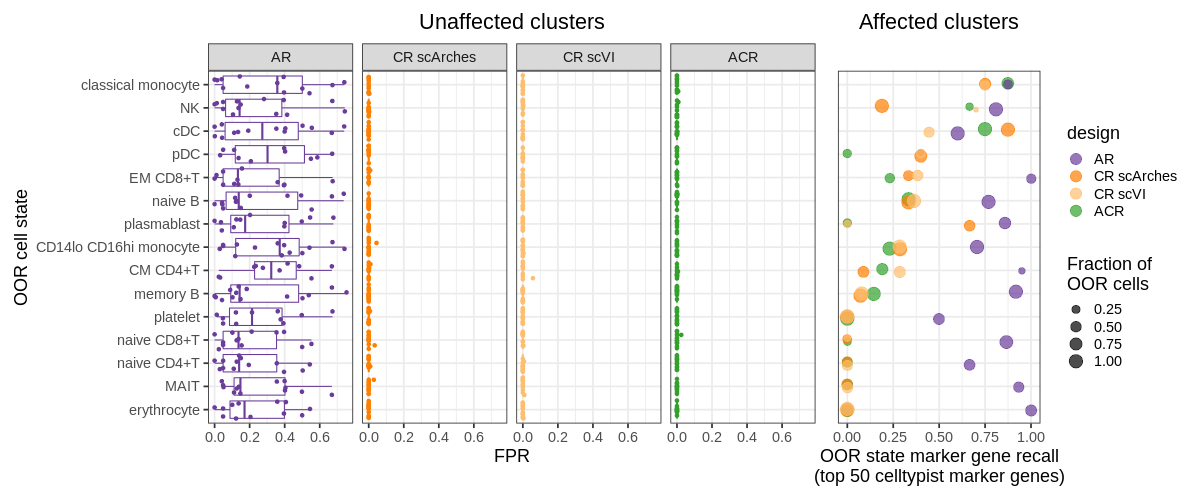

In [39]:
%%R -w 1200 -h 500 -i figdir
library(patchwork)
(pl1 + theme(legend.position='none', plot.title = element_text(hjust = 0.5)) | pl2 + remove_y_axis() + theme(plot.title = element_text(hjust = 0.5))) +
plot_layout(widths=c(3,1)) +
ggsave(paste0(figdir, "DE_comparison_metrics.png"), width=15, height=6) +
ggsave(paste0(figdir, "DE_comparison_metrics.pdf"), width=15, height=6)

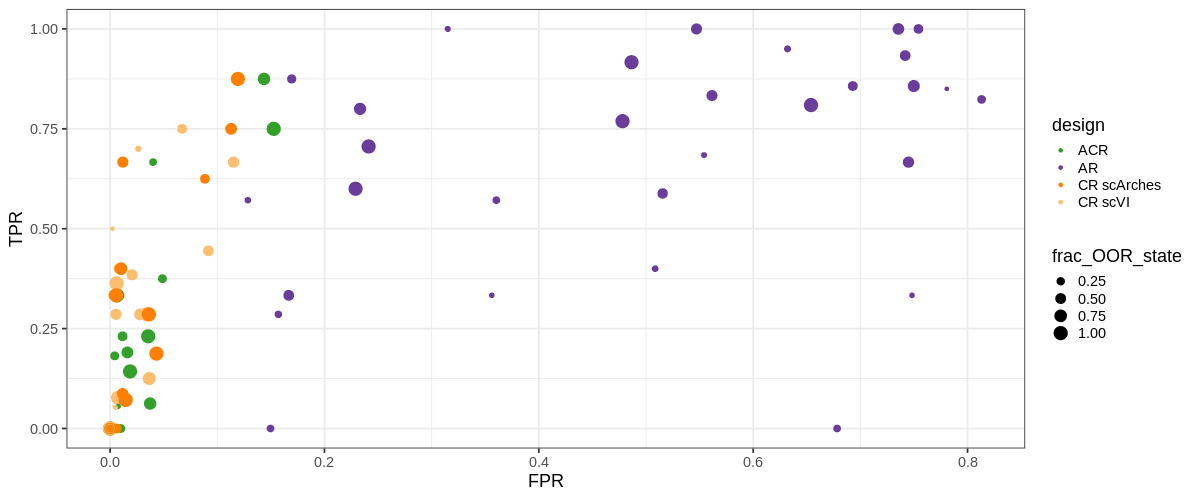

In [215]:
%%R -w 1200 -h 500
res_df_all %>%
filter(affected_anno) %>%
mutate(TPR=ifelse(is.na(TPR), 0, TPR)) %>%
group_by(OOR_state_simulation, design) %>%
mutate(frac_OOR_state = OOR_state/sum(OOR_state)) %>%
# slice_max(OOR_state, with_ties=FALSE) %>%
ungroup() %>%
group_by(OOR_state_simulation) %>%
mutate(mean_tpr= mean(TPR)) %>%
ungroup() %>%
arrange(mean_tpr) %>%
mutate(OOR_state_simulation = factor(OOR_state_simulation, levels=unique(OOR_state_simulation))) %>%
ggplot(aes(TPR, FPR, color=design)) +
geom_point(aes(size=frac_OOR_state), width=0.2) +
# geom_line(aes(group=OOR_state_simulation), color='grey') +
# facet_wrap(design~.) +
scale_color_manual(values=design_palette) +
theme_bw(base_size=18) +
coord_flip()

/tmp/ipykernel_28311/3681882512.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_28311/3681882512.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)
/tmp/ipykernel_28311/3681882512.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_28311/3681882512.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)
/tmp/ipykernel_28311/3681882512.py:21: MatplotlibDeprecationWarning: Aut

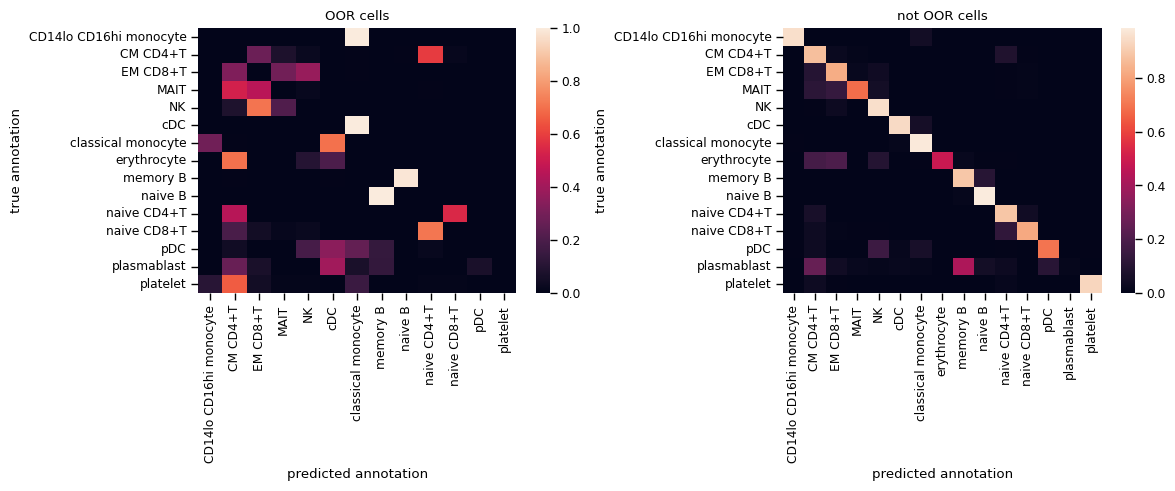

In [33]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_type') and x.endswith('_seed2022')]

sns.set_context('paper')


for design in ['AR.scArches','CR.scArches', 'CR.scVI', 'ACR.scArches']:
    plt.rcParams['figure.figsize'] = [12,5]
    pred_df_all = pd.DataFrame()
    for d in dirs:
        try:
            acr_pred = pd.read_csv(outdir + d + f'/DE_pred_annotations.{design}.csv')
        except:
            continue
        acr_pred = acr_pred[acr_pred['dataset_group'] == 'query']
        acr_pred['true annotation'] = [short_pop_names[x] for x in acr_pred['cell_annotation']]
        acr_pred['predicted annotation'] = [short_pop_names[x] for x in acr_pred['DE_cell_annotation']]
        acr_pred['simdir'] = d
        res_df = pd.concat([acr_pred])
        pred_df_all = pd.concat([pred_df_all, res_df])
    plt.subplot(1,2,1)
    sns.heatmap(sc.metrics.confusion_matrix('true annotation', 'predicted annotation', pred_df_all[pred_df_all['OOR_state'] == 1]));
    plt.title('OOR cells');
    plt.subplot(1,2,2)
    sns.heatmap(sc.metrics.confusion_matrix('true annotation', 'predicted annotation', pred_df_all[pred_df_all['OOR_state'] == 0]));
    plt.title('not OOR cells');
    plt.tight_layout();
    plt.savefig(figdir + f'conf_mat.{design}.pdf')

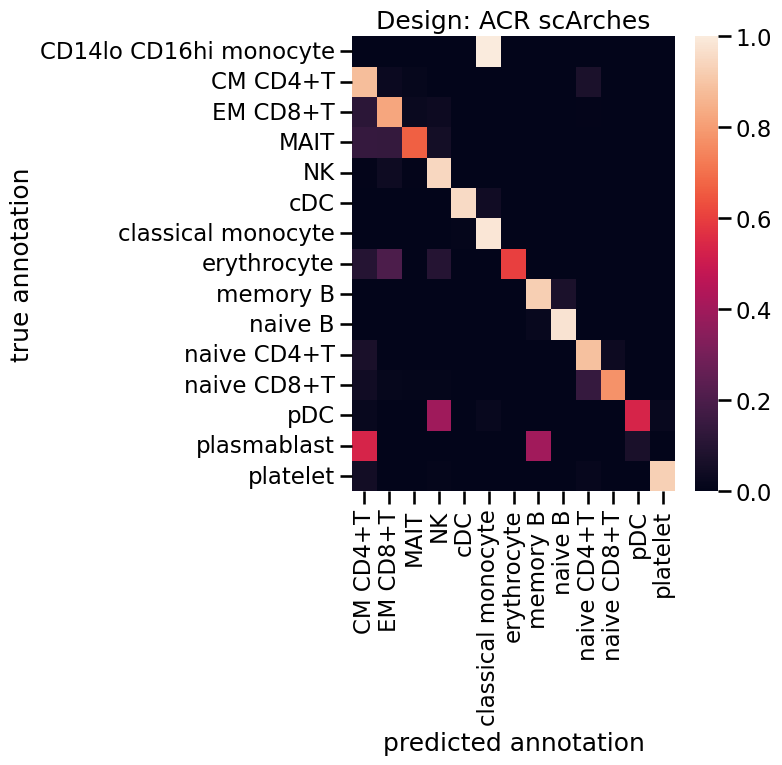

In [32]:
sns.set_context('talk');
plt.rcParams['figure.figsize'] = [8,8]
oor_state = 'CD14_low_CD16_positive_monocyte'
sns.heatmap(sc.metrics.confusion_matrix('true annotation', 'predicted annotation', acr_pred));
plt.title(f'Design: {design.replace(".", " ")}');
plt.tight_layout();
plt.savefig(figdir + f'conf_mat.example.pdf', bbox_inches='tight')